In [13]:
# Package Imports

import sklearn as sk
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from sqlalchemy import create_engine


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set the random seed so things are reproducible
random_state = 42

In [ ]:
#import the sql database with the polars function
conn = create_engine("sqlite:////home/troy/ml/project1/SentimentAnalysis.db")

#SQL query to get the date, close price, and sentiment score from the Database
SQLquery = """
SELECT 
    TS.Date AS StockDate,
    TS.Close AS StockClosingPrice,
    T.Score AS TweetScore
FROM 
    Tesla_Stock TS
JOIN 
    Tweet_data TD
ON 
    DATE(TS.Date) = DATE(TD.Creation_dt)
JOIN 
    Tweet_Scores T
ON 
    TD.ID = T.ID;

"""

df = pl.read_database(query=SQLquery, connection=conn)
df

StockDate,StockClosingPrice,TweetScore
str,f64,f64
"""2017-12-07""",311.24,0.0
"""2017-12-08""",315.13,1.0
"""2017-12-08""",315.13,1.0
"""2017-12-08""",315.13,1.0
"""2017-12-08""",315.13,-0.9626
…,…,…
"""2020-02-03""",780.0,1.1135
"""2020-02-03""",780.0,1.161
"""2020-02-03""",780.0,0.0


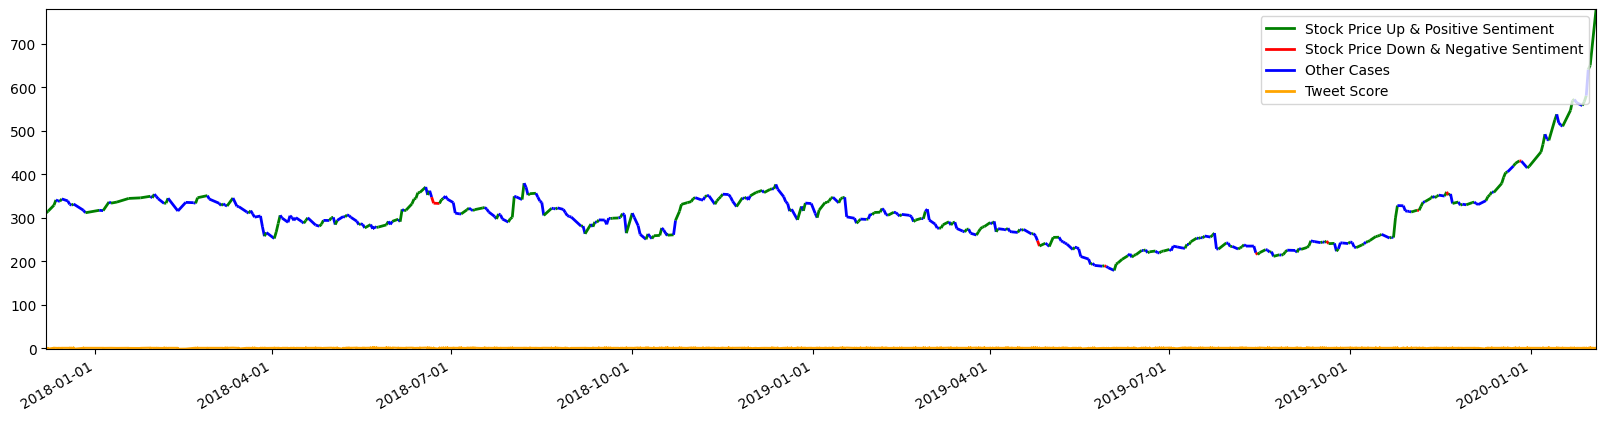

In [ ]:
# Convert dates to matplotlib numeric format
dates = mdates.date2num(df['StockDate'])
prices = df['StockClosingPrice'].to_numpy()  # Fixed: .to_numpy() instead of .values
scores = df['TweetScore'].to_numpy()         # Fixed: .to_numpy() instead of .values

# Create segments for the stock price line
points = np.array([dates, prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Calculate price differences and get corresponding scores
price_diff = np.diff(prices)
score_segment = scores[1:]

# Determine colors for each segment
colors = []
for pd, sc in zip(price_diff, score_segment):
    if pd > 0 and sc > 0:
        colors.append('green')
    elif pd < 0 and sc < 0:
        colors.append('red')
    else:
        colors.append('blue')

# Create LineCollection for stock price with segmented colors
lc = LineCollection(segments, colors=colors, linewidth=2)

# Plotting
plt.figure(figsize=(20, 5))
ax = plt.gca()
ax.add_collection(lc)

# Plot Tweet Score line
plt.plot(dates, scores, color='orange', label='Tweet Score')

# Format x-axis dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()

# Set axis limits
ax.set_xlim(dates.min(), dates.max())
ax.set_ylim(min(prices.min(), scores.min()), max(prices.max(), scores.max()))

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='Stock Price Up & Positive Sentiment'),
    Line2D([0], [0], color='red', lw=2, label='Stock Price Down & Negative Sentiment'),
    Line2D([0], [0], color='blue', lw=2, label='Other Cases'),
    Line2D([0], [0], color='orange', lw=2, label='Tweet Score')
]
plt.legend(handles=legend_elements)

plt.show()